In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.groupby('store').sales.describe()

,count,mean,std,min,25%,50%,75%,max
store,,,,,,,,
1,91300.0,47.268379,24.006252,1.0,28.0,44.0,63.0,155.0
2,91300.0,67.033165,33.595810,3.0,40.0,62.0,89.0,231.0
3,91300.0,59.530602,29.974102,3.0,35.0,55.0,80.0,196.0
4,91300.0,54.902946,27.733097,4.0,32.0,51.0,73.0,186.0
5,91300.0,39.770164,20.365757,2.0,23.0,37.0,53.0,130.0
6,91300.0,39.733516,20.310451,0.0,23.0,37.0,53.0,134.0
7,91300.0,36.363735,18.684825,1.0,21.0,34.0,49.0,122.0
8,91300.0,64.142048,32.231751,4.0,38.0,60.0,86.0,204.0
9,91300.0,55.049025,27.832186,4.0,32.0,51.0,74.0,195.0


In [5]:
df.groupby('item').sales.describe().head()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
1,18260.0,21.981599,8.468922,1.0,16.0,21.0,27.0,59.0
2,18260.0,58.574151,20.093015,9.0,44.0,56.0,71.0,150.0
3,18260.0,36.642223,13.179441,7.0,27.0,35.0,45.0,104.0
4,18260.0,22.010241,8.403898,0.0,16.0,21.0,27.0,66.0
5,18260.0,18.358708,7.265167,1.0,13.0,18.0,23.0,50.0


In [6]:
X = df[(df['item'] == 1) & (df['store'] == 1)][['date', 'sales']]

In [7]:
X['date'] = pd.to_datetime(X.date)

In [8]:
X_train = X[X.date < '2017-01-01']
X_test = X[X.date >= '2017-01-01']

<Axes: >

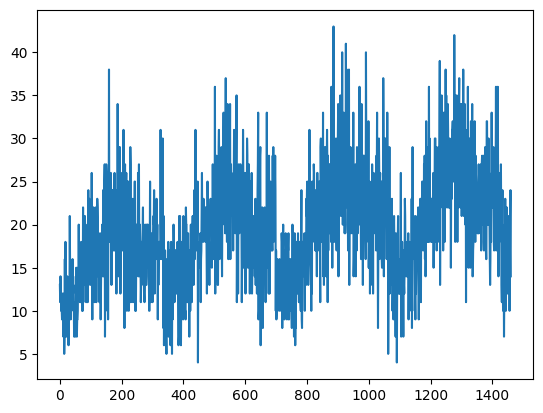

In [9]:
X_train.sales.plot()